In [1]:
import osmnx as ox
import geopandas as gpd

In [4]:
us_ufa = gpd.read_file('../data/d01_raw/FUA shapefiles/USA_core_commuting.shx')
boston_ufa = us_ufa.loc[us_ufa['fuaname'] == 'Boston'].reset_index()

In [8]:
boston_ufa = us_ufa.loc[us_ufa['fuaname'] == 'Boston'].reset_index()

<AxesSubplot:>

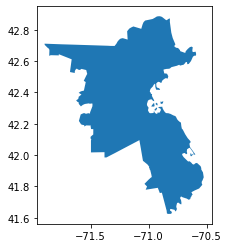

In [9]:
boston_ufa.plot()

Old code to convert latlong points to nodes in the graph (do not need that step)

In [ ]:
#from shapely.geometry import Point
#
## turn lat/lng lists into list of shapely points
#origin_longs, origin_lats = boston_od_df.intptlon.values, boston_od_df.intptlat.values
#dest_longs, dest_lats = boston_od_df.longitude.values, boston_od_df.latitude.values
#
#origin_pts_list = [Point((lng, lat)) for lng,lat in zip(origin_longs, origin_lats)]
#dest_pts_list = [Point((lng, lat)) for lng,lat in zip(dest_longs, dest_lats)]
#
##then turn list into GeoSeries:
#origin_pts = gpd.GeoSeries(origin_pts_list, crs='epsg:4326')
#dest_pts = gpd.GeoSeries(dest_pts_list, crs='epsg:4326')
#
##convert to graph crs:
#origin_pts_proj = origin_pts.to_crs(boston_walk_graph_proj.graph['crs'])
#dest_pts_proj = dest_pts.to_crs(boston_walk_graph_proj.graph['crs'])

#We do not need to do that step. The nearest nodes function already converts the lat long if we use the unprojected graph, which is less prone to mistake.

Checking what fuas we already have:

In [14]:
with open('../output.txt') as f:
    f_lines = f.readlines()
    good_fuas = [line.split('_')[0] for line in f_lines[1:]]

with open('../data/d02_processed-safegraph/safegraph_fua.txt') as g:
    g_lines = g.readlines()
    all_fuas = [line.split('_')[0].strip('\n') for line in g_lines]
    

def num(code):
    return int(code[3:])

good_fuas.sort(key=num)
all_fuas.sort(key=num)

In [19]:
remaining = list(set(all_fuas) - set(good_fuas))
remaining.sort(key=num)

In [20]:
remaining

['USA01', 'USA02', 'USA03', 'USA04', 'USA07', 'USA08', 'USA12', 'USA56']

In [21]:
outfile = open('../src/second_run.txt', 'w')
print('\n'.join(str(i) for i in remaining), file=outfile)
outfile.close()

In [1]:
import osmnx as ox
import geopandas as gpd
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
od_matrix = pd.read_csv('../data/d02_processed-safegraph/weeks_od_us_fua.csv')

In [6]:
od_matrix[od_matrix.fuacode=='USA80'].reset_index(drop=True)

,safegraph_place_id,census_block_group,top_category,latitude,longitude,fuacode,intptlat,intptlon
0,sg:001855be013b421688f5f8c2e724d076,550250114021,Restaurants and Other Eating Places,43.172181,-89.265802,USA80,43.126509,-89.271130
1,sg:001855be013b421688f5f8c2e724d076,550250022003,Restaurants and Other Eating Places,43.172181,-89.265802,USA80,43.120499,-89.366947
2,sg:001855be013b421688f5f8c2e724d076,550250115032,Restaurants and Other Eating Places,43.172181,-89.265802,USA80,43.201220,-89.244345
3,sg:001855be013b421688f5f8c2e724d076,550250118001,Restaurants and Other Eating Places,43.172181,-89.265802,USA80,43.214106,-89.098972
4,sg:001855be013b421688f5f8c2e724d076,551050029003,Restaurants and Other Eating Places,43.172181,-89.265802,USA80,42.783193,-89.312406
...,...,...,...,...,...,...,...,...
39488,sg:99688b865e1a4daa954a97821eb8318e,550659701001,"Museums, Historical Sites, and Similar Institu...",43.038467,-89.502189,USA80,42.784017,-89.892506
39489,sg:99688b865e1a4daa954a97821eb8318e,550250004072,"Museums, Historical Sites, and Similar Institu...",43.038467,-89.502189,USA80,43.040396,-89.499626
39490,sg:99688b865e1a4daa954a97821eb8318e,550250010002,"Museums, Historical Sites, and Similar Institu...",43.038467,-89.502189,USA80,43.054659,-89.435171
39491,sg:99688b865e1a4daa954a97821eb8318e,550250006001,"Museums, Historical Sites, and Similar Institu...",43.038467,-89.502189,USA80,43.032810,-89.452007


In [1]:
import pandas as pd

In [2]:
LA = pd.read_csv('../data/d04_final-OD-matrices/USA02_ODmatrix.csv')

In [7]:
LA2 = LA.drop(['Unnamed: 0', 'census_block_group', 'fuacode', 'origin_node', 'destination_node'], axis=1)
LA3 = LA2.rename({'intptlat':'cbg_latitude', 'intptlon':'cbg_longitude'})

In [22]:
dfs = [df[(df != 0).all(1)].sort_values(by='distance').reset_index(drop=True).dropna() for k, df in LA3.groupby('top_category')]

In [43]:
sampled_dfs = [df.sample(n=5, random_state=1).reset_index(drop=True) for df in dfs]
test_df = pd.concat(sampled_dfs).sort_values(by='distance').reset_index(drop=True)

In [44]:
test_df

,safegraph_place_id,top_category,latitude,longitude,intptlat,intptlon,mode,origin_node_dist,destination_node_dist,distance
0,sg:0ce07242959c4ac091d1749ed0d84a01,Religious Organizations,34.200773,-118.444980,34.198115,-118.445661,walk,43.400988,55.879747,222.538
1,sg:5f079d4aac244a799322d81952c5c9c6,Child Day Care Services,34.078581,-118.309030,34.078063,-118.306845,walk,49.661400,34.042379,284.753
2,sg:6d271cebc58145888d4302542f683ef9,Elementary and Secondary Schools,33.878736,-117.869035,33.880393,-117.870665,walk,43.212612,19.493258,608.517
3,sg:458acd8086fc4043a25d2723736b17a7,Health and Personal Care Stores,34.129548,-117.871938,34.132640,-117.869416,walk,36.675391,26.836200,700.539
4,sg:94d8a7c4b5ef419daae8e8215733c5d2,Grocery Stores,33.885054,-118.407826,33.888873,-118.406190,walk,13.024292,25.176015,788.663
5,sg:2864da96288241a09c5b3c07b11655f3,Health and Personal Care Stores,34.008526,-118.277976,34.014348,-118.272778,walk,62.397335,41.737418,1042.739
6,sg:1bb52600a6a84b7f82ab3e818ae381ce,Restaurants and Other Eating Places,34.063862,-117.612087,34.065281,-117.619757,walk,69.365935,30.372873,1145.518
7,sg:20a1fb3275534e6a826ab4b321c50e82,Other Amusement and Recreation Industries,34.058992,-118.387308,34.057436,-118.368136,walk,125.659493,12.709289,1801.552
8,sg:2b4c8d82c41b4a40b41b8bd09abb6fb9,Child Day Care Services,34.205110,-118.378004,34.192122,-118.381776,walk,50.748526,22.569792,1816.566
9,sg:0efb71742a404c43992bffa84721361a,Specialty Food Stores,33.972774,-118.079778,33.956574,-118.081074,drive,76.990332,66.289230,2113.053


In [ ]:
LA.to_csv('../data/checking-distance-LA')

In [4]:
import pandas as pd

original_csv = pd.read_csv('../data/d02_processed-safegraph/weeks_od_us_fua_FIRST.csv')
new_csv = pd.read_csv('../data/d02_processed-safegraph/weeks_od_us_fua.csv')


In [5]:
len(original_csv)

19307834

In [6]:
len(new_csv)

31129485

In [7]:
original_csv.head()

,safegraph_place_id,census_block_group,top_category,latitude,longitude,fuacode,intptlat,intptlon
0,sg:0000151bf1ed4fe3a39f1b27327821bf,60830023064,Restaurants and Other Eating Places,34.950098,-120.43797,USA107,34.970034,-120.467048
1,sg:0000151bf1ed4fe3a39f1b27327821bf,60830020112,Restaurants and Other Eating Places,34.950098,-120.43797,USA107,34.905334,-120.461681
2,sg:0000151bf1ed4fe3a39f1b27327821bf,60830024022,Restaurants and Other Eating Places,34.950098,-120.43797,USA107,34.936875,-120.468372
3,sg:0000151bf1ed4fe3a39f1b27327821bf,60830024042,Restaurants and Other Eating Places,34.950098,-120.43797,USA107,34.944654,-120.449254
4,sg:0000151bf1ed4fe3a39f1b27327821bf,60830023043,Restaurants and Other Eating Places,34.950098,-120.43797,USA107,34.958741,-120.449052


In [14]:
new_csv['id'] = new_csv['safegraph_place_id'].astype(str) + new_csv['census_block_group'].astype(str)
original_csv['id'] = original_csv['safegraph_place_id'].astype(str) + original_csv['census_block_group'].astype(str)

In [23]:
common = new_csv.merge(original_csv, on='id')
result = new_csv[~new_csv.id.isin(common.id)]

In [27]:
result.drop(['id'], axis=1, inplace=True)

/Users/gsagostini/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [29]:
to_save = result.reset_index(drop=True)

In [31]:
len(to_save)

11821651

In [32]:
to_save.to_csv('../data/d02_processed-safegraph/weeks_od_us_fua_NEW.csv')